# K-Nearest Neighbors
In this experiment, we use the K-Nearest Neighbors (KNN) algorithm to classify varieties of the Iris dataset.

In [34]:
# Import necessary libraries
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import pyplot

In order to access the dataset, you may download it from the following [link](https://gist.github.com/netj/8836201) or load it from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

In [35]:
df = pd.read_csv("Datasets/iris.csv")
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


For this experiment, we will assign Setosa to class $0$, Versicolor to class $1$, and Virginica to class $2$.

In [3]:
df.loc[df["variety"] == "Setosa", "variety"] = 0. # Change Setosa to class 0
df.loc[df["variety"] == "Versicolor", "variety"] = 1. # Change Versicolor to class 1
df.loc[df["variety"] == "Virginica", "variety"] = 2. # Change Virginica to class 2
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


We now split our dataset into the train, test, and validation sets. For this experiment, we will only use petal length and petal width as our features. The train set consists of 40 samples per class (120 samples in total), the test set consists of 9 samples per class (27 samples in total), and the validation set consists of 1 sample per class (3 samples in total).

In [5]:
x0 = torch.tensor(df.iloc[0:,2].values, dtype=torch.float32) # Petal length
x0_train = torch.cat((x0[:40], x0[50:90], x0[100:140]))
x0_test = torch.cat((x0[40:49], x0[90:99], x0[140:149]))
x0_valid = torch.tensor([x0[49],x0[99],x0[149]])

x1 = torch.tensor(df.iloc[0:,3].values, dtype=torch.float32) # Petal width
x1_train = torch.cat((x1[:40], x1[50:90], x1[100:140]))
x1_test = torch.cat((x1[40:49], x1[90:99], x1[140:149]))
x1_valid = torch.tensor([x1[49],x1[99],x1[149]])

y = torch.tensor(df.iloc[0:,4].values.astype(np.float32), dtype=torch.float32) # Variety
y_train = torch.cat((y[:40], y[50:90], y[100:140]))
y_test = torch.cat((y[40:49], y[90:99], y[140:149]))
y_valid = torch.tensor([y[49],y[99],y[149]])

Let us first look at the training data separated per class. Upon observation, we see that the Setosa class is easily distinguisable from the other two classes. However, we see some overlapping samples between the Versicolor and the Virginica classes.

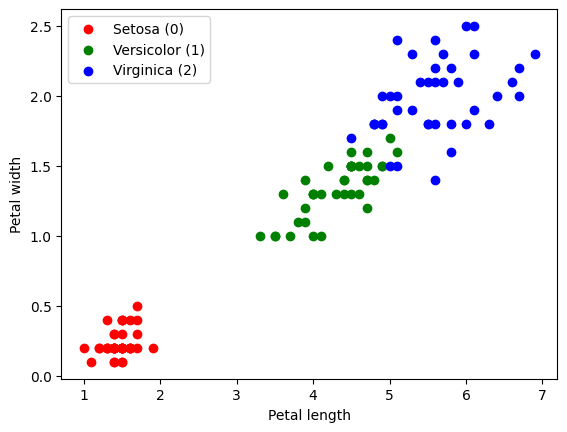

In [6]:
plt.scatter(x0_train[:40], x1_train[:40], label='Setosa (0)', color='red')
plt.scatter(x0_train[40:80], x1_train[40:80], label='Versicolor (1)', color='green')
plt.scatter(x0_train[80:], x1_train[80:], label='Virginica (2)', color='blue')
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend()
pyplot.show()

We now construct our K-Nearest Neighbors model class. We used [Towards Data Science](https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e) as our reference for the formulas used. The function $ed$ computes for the Euclidean distance between the input data and the training data, while $forward$ determines the nearest neighbors using $torch.topk$ and returns the predicted class. For this model, we set the default $k$ to $3$ nearest neighbors.

In [36]:
class KNearestNeighbors():
    def __init__(self, _x0, _x1, _y, k=3):
        self._x0 = _x0
        self._x1 = _x1
        self._y = _y
        self.k = k

    def ed(self, x0, x1):
        return torch.sqrt(torch.pow(self._x0 - x0, 2) + torch.pow(self._x1 - x1, 2))

    def forward(self, x0, x1):
        d = self.ed(x0, x1)
        tk = torch.topk(d, self.k, largest=False).indices
        n_class = torch.mode(self._y[tk]).values.item()
        return n_class

    def test(self, x0, x1, y):
        if x0.shape != x1.shape:
            raise Exception("Feature shapes must match with each other")
        if x0.dim() == 0 and x1.dim() == 0:
            pred = self.forward(x0,x1)
            print(f'Prediction: {pred} | Actual: {y}')
        else:
            correct = 0
            for i, v in enumerate(x0):
                pred = self.forward(v,x1[i])
                print(f'Prediction: {pred} | Actual: {y[i]}')
                correct = correct + 1 if pred == y[i] else correct
            print(f'\nTest accuracy: {(correct/list(y.shape)[0]) * 100.}%')

    def infer(self, x0, x1,log=False):
        if x0.shape != x1.shape:
            raise Exception("Feature shapes must match with each other")
        if x0.dim() == 0 and x1.dim() == 0:
            pred = self.forward(x0,x1)
            if log == True:
                print(f'Prediction: {pred}')
            return pred
        else:
            preds = torch.zeros(x0.shape[0])
            for i, v in enumerate(x0):
                pred = self.forward(v,x1[i])
                if log == True:
                    print(f'Prediction: {pred}')
                preds[i] = pred
            return preds

Let us now test our model with the test data. After shuffling the test dataset and feeding it into our KNN model, we observe a $100\%$ accuracy as it correctly predicts all test samples.

In [37]:
if __name__ == "__main__":
    knn = KNearestNeighbors(x0_train, x1_train, y_train)
    # Shuffle test data
    i = torch.randperm(x0_test.shape[0])
    x0_test = x0_test[i].view(x0_test.size())
    x1_test = x1_test[i].view(x1_test.size())
    y_test = y_test[i].view(y_test.size())
    # Test KNN model on shuffled test dataset
    knn.test(x0_test,x1_test,y_test)

Prediction: 0.0 | Actual: 0.0
Prediction: 2.0 | Actual: 2.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 0.0 | Actual: 0.0
Prediction: 1.0 | Actual: 1.0
Prediction: 0.0 | Actual: 0.0
Prediction: 2.0 | Actual: 2.0
Prediction: 2.0 | Actual: 2.0
Prediction: 0.0 | Actual: 0.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 2.0 | Actual: 2.0
Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 2.0 | Actual: 2.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 0.0 | Actual: 0.0
Prediction: 2.0 | Actual: 2.0
Prediction: 2.0 | Actual: 2.0
Prediction: 2.0 | Actual: 2.0
Prediction: 0.0 | Actual: 0.0
Prediction: 2.0 | Actual: 2.0

Test accuracy: 100.0%


In order to validate our model and observe the data better, we plot the shuffled validation data samples along with the training data and include the predictions of our KNN model. We observe that the KNN model correctly predicts the samples. To emphasize, even when the validation sample of the Virginica class is right around the middle of the Versicolor and Virginica classes, it still correctly predicts it actual class.

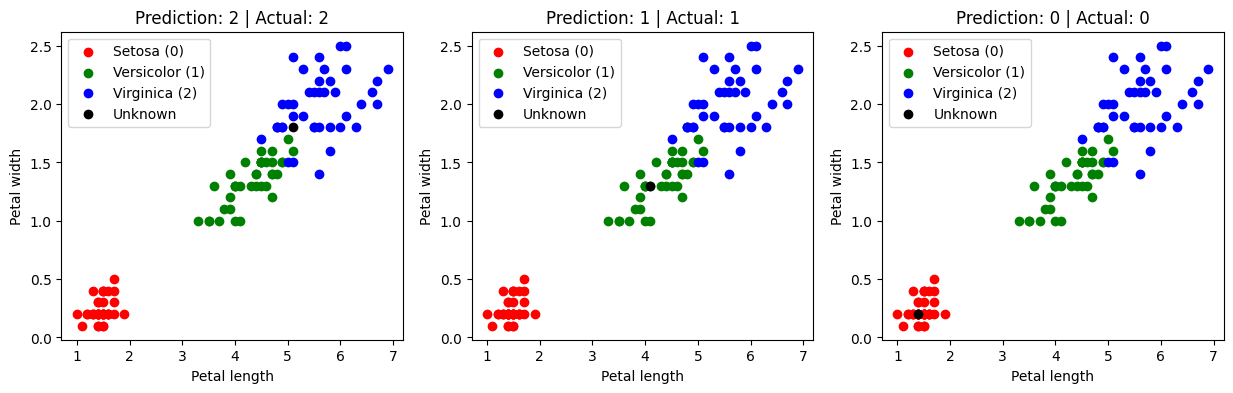

In [38]:
i = torch.randperm(x0_valid.shape[0])
x0_valid = x0_valid[i].view(x0_valid.size())
x1_valid = x1_valid[i].view(x1_valid.size())
y_valid = y_valid[i].view(y_valid.size())

fig = plt.figure(figsize=(15, 4))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.scatter(x0_train[:40], x1_train[:40], label='Setosa (0)', color='red')
plt.scatter(x0_train[40:80], x1_train[40:80], label='Versicolor (1)', color='green')
plt.scatter(x0_train[80:], x1_train[80:], label='Virginica (2)', color='blue')
pred = int(knn.infer(x0_valid[0], x1_valid[0]))
plt.scatter(x0_valid[0], x1_valid[0], label='Unknown', color='black')
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title(f'Prediction: {pred} | Actual: {int(y_valid[0])}')
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.scatter(x0_train[:40], x1_train[:40], label='Setosa (0)', color='red')
plt.scatter(x0_train[40:80], x1_train[40:80], label='Versicolor (1)', color='green')
plt.scatter(x0_train[80:], x1_train[80:], label='Virginica (2)', color='blue')
pred = int(knn.infer(x0_valid[1], x1_valid[1]))
plt.scatter(x0_valid[1], x1_valid[1], label='Unknown', color='black')
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title(f'Prediction: {pred} | Actual: {int(y_valid[1])}')
plt.legend()

fig.add_subplot(rows, columns, 3)
plt.scatter(x0_train[:40], x1_train[:40], label='Setosa (0)', color='red')
plt.scatter(x0_train[40:80], x1_train[40:80], label='Versicolor (1)', color='green')
plt.scatter(x0_train[80:], x1_train[80:], label='Virginica (2)', color='blue')
pred = int(knn.infer(x0_valid[2], x1_valid[2]))
plt.scatter(x0_valid[2], x1_valid[2], label='Unknown', color='black')
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title(f'Prediction: {pred} | Actual: {int(y_valid[2])}')
plt.legend()

plt.show()